## Clustering

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
# Loading the dataset
with open('data/patient_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
data.head()

,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing
0,A,53.0,Male,NaN,True,True,33.0,Good,1,1,0
1,F,85.0,Female,7.0,False,False,No TTM,Good,1,0,0
2,A,48.0,Male,NaN,True,True,36.0,Good,1,1,0
3,A,45.0,Male,NaN,True,True,33.0,Good,1,1,0
4,D,51.0,Male,24.0,True,True,33.0,Good,1,0,0


### Check Datatypes

In [3]:
# Check the datatypes of the loaded data
data.dtypes

hospital                    category
age                          float64
sex                         category
rosc                         float64
ohca                        category
shockable_rhythm            category
ttm                         category
outcome                     category
cpc                            int64
rosc_missing                   int64
shockable_rhythm_missing       int64
dtype: object

In [4]:
# Define the order of values for the 'cpc' column
cpc_order = [1, 2, 3, 4, 5]

# Convert 'cpc' to an ordinal category
data['cpc'] = pd.Categorical(data['cpc'], categories=cpc_order, ordered=True)

In [5]:
for col in data.columns:
    if data[col].apply(type).nunique() > 1:
        print(f"Column '{col}' has mixed types: {data[col].apply(type).unique()}")

Column 'ohca' has mixed types: [<class 'bool'> <class 'str'>]
Column 'shockable_rhythm' has mixed types: [<class 'bool'> <class 'str'>]
Column 'ttm' has mixed types: [<class 'float'> <class 'str'>]


In [6]:
# Explicitly convert the nominal categorical variables, that were objects before
data['ohca'] = data['ohca'].astype(str)
data['shockable_rhythm'] = data['shockable_rhythm'].astype(str)
data['ttm'] = data['ttm'].astype(str)

### Preprocessing before clustering

In [7]:
# Encoding categorical variables
encoder = OneHotEncoder()
encoded_categorical = encoder.fit_transform(data[['sex', 'ohca', 'shockable_rhythm', 'outcome', 'ttm']]).toarray()

# Create a DataFrame for the encoded variables
encoded_data = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out())

# Use median to fill missing values in rosc because there are outliers
data['rosc'] = data['rosc'].fillna(data['rosc'].median())

# Combine with the numeric and ordinal variables
processed_data = pd.concat([data[['age', 'rosc', 'cpc']], encoded_data], axis=1)

# Standardize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(processed_data)

processed_data.head()

,age,rosc,cpc,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,outcome_Good,outcome_Poor,ttm_33.0,ttm_36.0,ttm_No TTM
0,53.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,85.0,7.0,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,48.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,45.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,51.0,24.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


### KMeans Clustering

For n_clusters = 2, the average silhouette score is: 0.31176255385131335
For n_clusters = 3, the average silhouette score is: 0.25950774411292166
For n_clusters = 4, the average silhouette score is: 0.30083888268227965
For n_clusters = 5, the average silhouette score is: 0.29896146787711547
For n_clusters = 6, the average silhouette score is: 0.32750387218723326
For n_clusters = 7, the average silhouette score is: 0.36143005251499455
For n_clusters = 8, the average silhouette score is: 0.39018598364047524
For n_clusters = 9, the average silhouette score is: 0.4092222030425726
For n_clusters = 10, the average silhouette score is: 0.4512365239463345


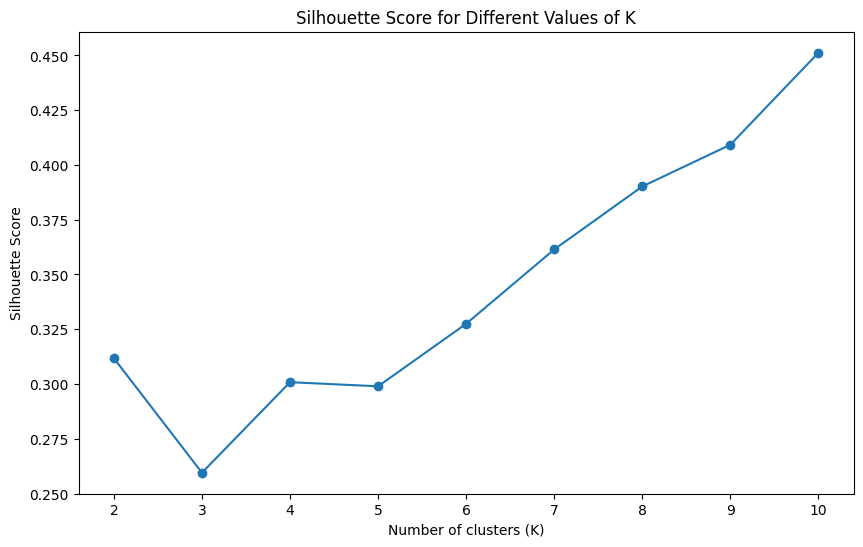

In [8]:
# Decide the number of k
# Initialize lists to hold values for plotting
silhouette_scores = []
k_values = range(2, 11)

# Iterate over different values of K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=2023)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette score is: {silhouette_avg}")

# Plot silhouette scores to find the best K
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of K')
plt.show()

In [9]:
# Perform K-means clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=2023)
kmeans.fit(scaled_data)

# Add cluster labels to the DataFrame
processed_data['cluster'] = kmeans.labels_

# Display the first few rows of the data with cluster labels
processed_data.head()

,age,rosc,cpc,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,outcome_Good,outcome_Poor,ttm_33.0,ttm_36.0,ttm_No TTM,cluster
0,53.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,85.0,7.0,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7
2,48.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,45.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,51.0,24.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [10]:
# Count the number of data points in each cluster
cluster_counts = processed_data['cluster'].value_counts()

# Display the counts for each cluster
print(cluster_counts)

cluster
0    131
3     91
5     82
4     76
1     61
6     53
9     31
7     29
2     27
8     26
Name: count, dtype: int64


### Cluster analysis

Cluster Summary (Means):
                age       rosc
cluster                      
0        58.557252  18.824427
1        60.426230  23.016393
2        65.925926  19.000000
3        65.032967  22.340659
4        63.157895  19.750000
5        63.121951  24.707317
6        55.641509  20.018868
7        53.902356  18.758621
8        65.884615  22.192308
9        60.419355  22.612903

Cluster Summary (Categorical Mode):
         cpc  sex_Female  sex_Male  ohca_False  ohca_True  ohca_Unknown  \
cluster                                                                  
0         1         0.0       1.0         0.0        1.0           0.0   
1         5         1.0       0.0         0.0        1.0           0.0   
2         5         0.0       1.0         0.0        0.0           1.0   
3         5         0.0       1.0         0.0        1.0           0.0   
4         5         0.0       1.0         1.0        0.0           0.0   
5         5         0.0       1.0         0.0        1.0  

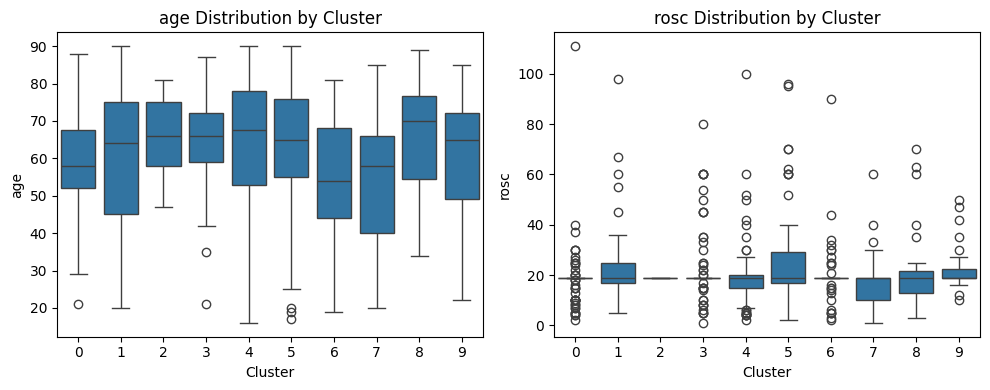

In [11]:
# Define your numeric and categorical features
numeric_features = ['age', 'rosc']
categorical_features = [
    'cpc', 'sex_Female', 'sex_Male', 
    'ohca_False', 'ohca_True', 'ohca_Unknown', 
    'shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown', 
    'outcome_Good', 'outcome_Poor',
    'ttm_33.0','ttm_36.0', 'ttm_No TTM'
    ]

# Calculate means for numeric features grouped by cluster
cluster_summary_numeric = processed_data.groupby('cluster')[numeric_features].mean()
print("Cluster Summary (Means):\n", cluster_summary_numeric)

# Calculate mode for categorical features grouped by cluster
cluster_summary_categorical = processed_data.groupby('cluster')[categorical_features].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)
print("\nCluster Summary (Categorical Mode):\n", cluster_summary_categorical)

# Visual Analysis
# Number of features to plot
num_features = len(numeric_features)

# Create a figure with subplots
fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 4))  # Adjust figsize as needed

# Loop through the numeric features and create a box plot for each
for ax, feature in zip(axes, numeric_features):
    sns.boxplot(x='cluster', y=feature, data=processed_data, ax=ax)
    ax.set_title(f'{feature} Distribution by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

# Adjust layout
plt.tight_layout()
plt.show()

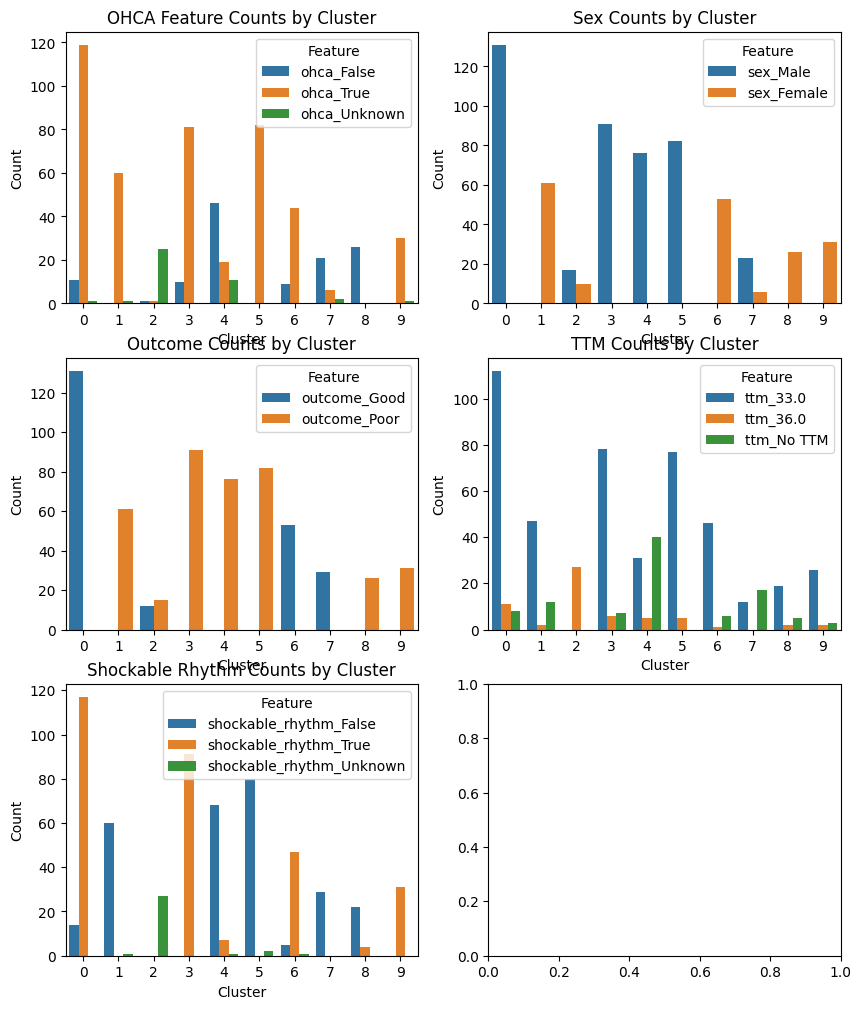

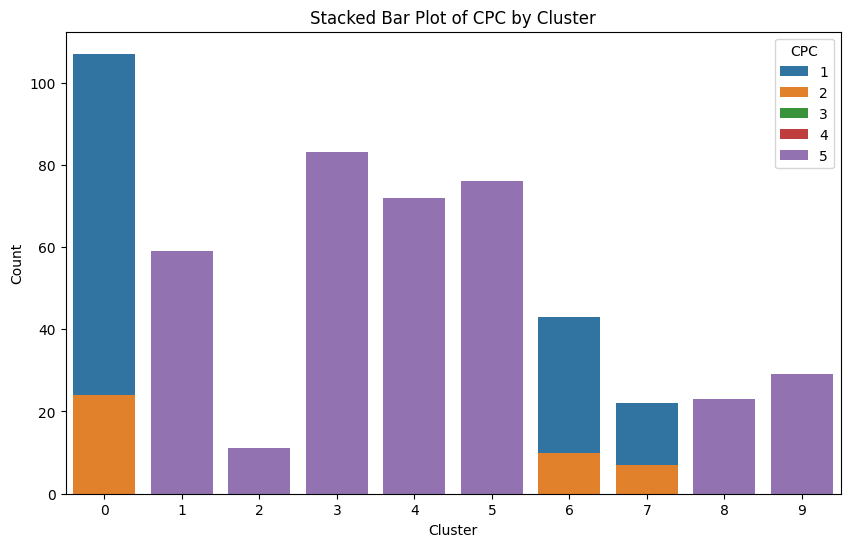

<Figure size 640x480 with 0 Axes>

In [12]:
# Define features and titles for plotting
features_list = [
    (['ohca_False', 'ohca_True', 'ohca_Unknown'], 'OHCA Feature Counts by Cluster'),
    (['sex_Male', 'sex_Female'], 'Sex Counts by Cluster'),
    (['outcome_Good', 'outcome_Poor'], 'Outcome Counts by Cluster'),
    (['ttm_33.0', 'ttm_36.0', 'ttm_No TTM'], 'TTM Counts by Cluster'),
    (['shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown'], 'Shockable Rhythm Counts by Cluster')
]

# Calculate number of plots
num_plots = len(features_list)

# Determine number of rows and columns
num_rows = 3
num_cols = (num_plots + 1) // num_rows  # Calculate columns needed for 2 rows

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

# Flatten axes array for easy indexing if there are multiple rows
axes = axes.flatten()

# Loop through the features and create a bar plot for each
for ax, (features, title) in zip(axes, features_list):
    melted_data = processed_data.melt(id_vars='cluster', value_vars=features, 
                                       var_name='Feature', value_name='Count')
    sns.barplot(x='cluster', y='Count', hue='Feature', data=melted_data, estimator=sum, ax=ax, errorbar=None)
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.legend(title='Feature')

# Stacked bar plot for 'cpc'
plt.figure(figsize=(10, 6))
sns.countplot(data=processed_data, x='cluster', hue='cpc', dodge=False)
plt.title('Stacked Bar Plot of CPC by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='CPC')
plt.show()

# Adjust layout
plt.tight_layout()
plt.show()

### Clustering Result Analysis

To investigate the subtypes of patients who may benefit from targeted temperature management (TTM), we will focus on the clusters with good outcomes, specifically clusters 0, 6, and 7.

Cluster 0 consists solely of males, primarily those who experienced out-of-hospital cardiac arrest, with a majority exhibiting shockable rhythms. Most patients in this cluster received TTM at 33.0°C. The mean age of this group is 58.5 years, and the mean time to return of spontaneous circulation (ROSC) is 18.8 minutes.
- Cluster 3 shares many of the same categorical characteristics as Cluster 0 but is associated with poor outcomes. In Cluster 3, the mean age is older at 65 years, and the mean time to ROSC is slightly longer at 22 minutes. 
- Cluster 5 is also nearly identical to Cluster 3, but with mostly non-shockable rhythms. This cluster also has poor outcomes, with a mean age of 63.1 years and a mean time to ROSC of 24.7 minutes.
- This indicates that age and time to rosc is important, and whether the rhythm is shockable or not doesn't really influence the outcome

Cluster 6 consists entirely of females. Its categorical characteristics are almost identical to those of Cluster 0: predominantly out-of-hospital cardiac arrests, mostly shockable rhythms, and primarily managed with TTM at 33.0°C. The mean age of this group is 55 years, and the mean time to ROSC is 20 minutes.
- This indicates that gender doesn't influence the outcome

Cluster 7 predominantly includes males and primarily consists of in-hospital cardiac arrests. This cluster has nearly equal numbers of patients receiving no TTM and those managed with TTM at 33.0°C, with a non-shockable rhythm. The mean age in this cluster is 53 years, and the mean time to ROSC is 18 minutes.
- this indicates that whether the cardiac arrest happens in hospital or out of hospital doen't influence the outcome

### Conclusion
1. Clusters with good outcomes are primarily managed with TTM at 33.0°C.
2. Some clusters experience poor outcomes despite being managed with TTM at 33.0°C, particularly those with a mean age over 60 and ROSC times exceeding 20 minutes.
3. Therefore, factors that appear to influence outcomes include being under the age of 60 and having a ROSC time of 20 minutes or less.
